In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
from statsmodels.api import add_constant, OLS
from statsmodels.tsa.stattools import coint, adfuller
from copy import deepcopy as dc

In [2]:
raw_data = pd.read_csv("../data/raw_data.csv", index_col=0)
raw_data.index = pd.to_datetime(raw_data.index)
raw_data.head()

,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,40.689999,40.910000,26.337500,57.610001,42.930000,22.950001,101.830002,91.970001,54.439999,35.840000,...,124.980133,29.83,68.769997,35.700001,77.459999,36.080002,51.912292,98.844658,66.489998,47.270000
2016-01-05,40.549999,40.520000,25.677500,57.369999,42.919998,23.033333,102.360001,92.339996,54.040001,36.240002,...,125.839996,29.90,70.070000,36.060001,78.120003,36.070000,51.782890,100.902916,64.820000,48.009998
2016-01-06,40.730000,41.230000,25.174999,57.380001,42.560001,23.070000,102.160004,91.019997,51.740002,35.360001,...,125.839996,29.24,66.440002,36.439999,77.470001,35.619999,51.416248,101.339806,62.230000,48.020000
2016-01-07,39.000000,40.450001,24.112499,57.209999,41.540001,23.046667,99.160004,89.110001,50.419998,34.520000,...,114.949997,28.16,60.189999,36.580002,76.230003,34.700001,49.662113,99.009712,59.410000,46.560001
2016-01-08,38.590000,40.369999,24.240000,55.650002,40.669998,22.806667,98.199997,87.849998,49.980000,34.389999,...,116.620003,27.90,57.740002,36.180000,74.690002,34.369999,48.986340,98.592232,59.250000,45.880001


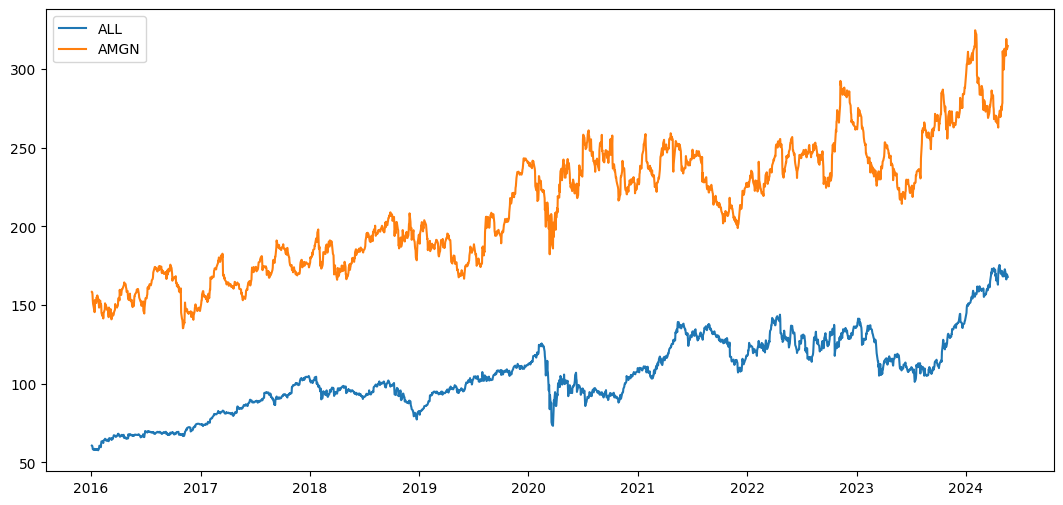

In [3]:
stock1 = 'ALL'
stock2 = 'AMGN'
plt.figure(figsize=(13, 6))
plt.plot()
plt.plot(raw_data.index, raw_data.loc[:, stock1], label=stock1)
plt.plot(raw_data.index, raw_data.loc[:, stock2], label=stock2)
plt.legend()
plt.show()

In [4]:
def compute_spread(data, stock1, stock2):
    # lp = np.log(data)
    # S1 = lp[stock1]
    S1 = data[stock1]
    S1 = add_constant(S1)
    # S2 = lp[stock2]
    S2 = data[stock2]
    linear_regression = OLS(S2, S1).fit()
    S1 = S1[stock1]
    beta = linear_regression.params[stock1]
    spread = S2 - beta * S1
    return spread

def zscore_normalization(data):
    return (data - data.mean()) / data.std()

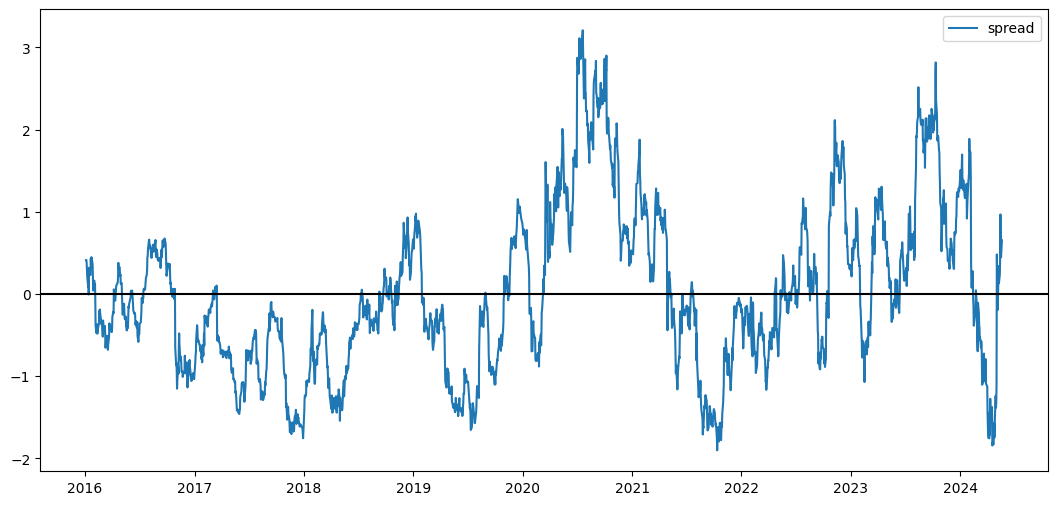

In [5]:
spread = compute_spread(raw_data, stock1, stock2)
spread = zscore_normalization(spread)
plt.figure(figsize=(13, 6))
plt.plot()
plt.plot(spread, label='spread')
plt.axhline(spread.mean(), color='black')
plt.legend()
plt.show()

In [14]:
score, coint_pvalue, _ = coint(raw_data.loc[:, stock1], raw_data.loc[:, stock2])
print(f"Co-integration test p_value: {coint_pvalue}")
adf = adfuller(spread)
print(f"Adfuller test p_value: {adf[1]}")

Co-integration test p_value: 7.425392001652205e-05
Adfuller test p_value: 9.439906749097269e-05


In [7]:
spread = pd.DataFrame(spread)
spread.rename(columns={0:"Spread"}, inplace=True)
# spread.to_csv(f"../data/spread/spread_{stock1}_{stock2}.csv")
spread.head()

,Spread
Date,
2016-01-04,0.787638
2016-01-05,0.800309
2016-01-06,0.879969
2016-01-07,0.992428
2016-01-08,1.064469


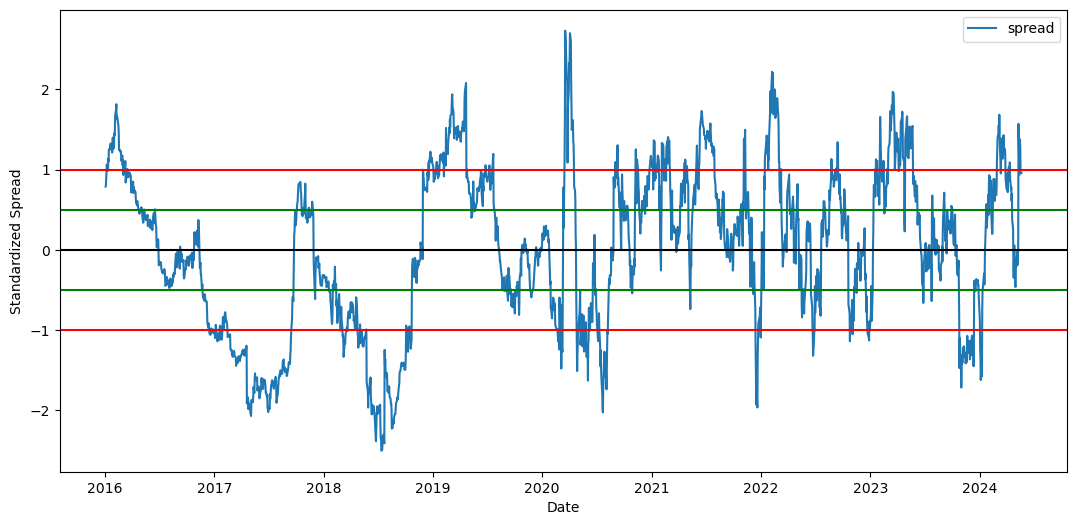

In [8]:
from TradingAgent import PairsTradingAgent
trading_agent = PairsTradingAgent(raw_data.loc[:, stock1], raw_data.loc[:, stock2], spread,
                                  entry=1.0, exit=0.5)
trading_agent.plot_threshold()

In [9]:
portfolio1 = dc(trading_agent.trading_simulation(entry=1.0, exit=0.5))
portfolio2 = dc(trading_agent.trading_simulation(entry=1.2, exit=0.5))
portfolio3 = dc(trading_agent.trading_simulation(entry=1.4, exit=0.5))
portfolio4 = dc(trading_agent.trading_simulation(entry=1.6, exit=0.5))
portfolio5 = dc(trading_agent.trading_simulation(entry=1.8, exit=0.5))

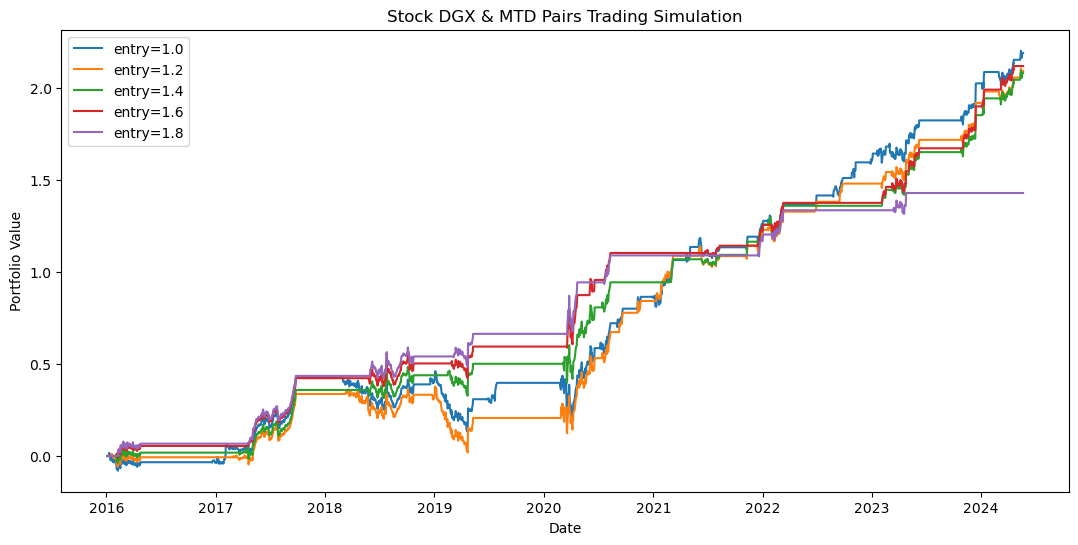

In [10]:
plt.figure(figsize=(13, 6))
plt.plot()
plt.plot(portfolio1, label='entry=1.0')
plt.plot(portfolio2, label='entry=1.2')
plt.plot(portfolio3, label='entry=1.4')
plt.plot(portfolio4, label='entry=1.6')
plt.plot(portfolio5, label='entry=1.8')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.title(f"Stock {stock1} & {stock2} Pairs Trading Simulation")
plt.show()

In [11]:
# spread.to_csv(f"../data/spread/spread_{stock1}_{stock2}.csv")